In [144]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [145]:
df = pd.read_csv("../Data/Train_TEC_mar17.csv")
df.head()

,Date,Month,Year,Time,LT,TEC
0,1,3,2017,0.016389,5.311333,2.067562
1,1,3,2017,0.049722,5.344670,2.082707
2,1,3,2017,0.083056,5.378006,2.004272
3,1,3,2017,0.116389,5.411343,1.736569
4,1,3,2017,0.149722,5.444679,1.758503


In [146]:
df['Date'] = df.apply(lambda row: datetime(
                              row['Year'].astype('int'), row['Month'].astype('int'), row['Date'].astype('int')), axis=1)

In [147]:
df.head()

,Date,Month,Year,Time,LT,TEC
0,2017-03-01,3,2017,0.016389,5.311333,2.067562
1,2017-03-01,3,2017,0.049722,5.344670,2.082707
2,2017-03-01,3,2017,0.083056,5.378006,2.004272
3,2017-03-01,3,2017,0.116389,5.411343,1.736569
4,2017-03-01,3,2017,0.149722,5.444679,1.758503


In [148]:
df.drop(["Month", "Year", "LT","Date","Time"], axis = 1, inplace = True)

In [149]:
df.head()

,TEC
0,2.067562
1,2.082707
2,2.004272
3,1.736569
4,1.758503


In [150]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [151]:
TRAIN_SPLIT = 14400

In [152]:
tf.random.set_seed(13)


In [153]:
uni_data = df['TEC']
uni_data.head()

0    2.067562
1    2.082707
2    2.004272
3    1.736569
4    1.758503
Name: TEC, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025E842CDC08>],
      dtype=object)

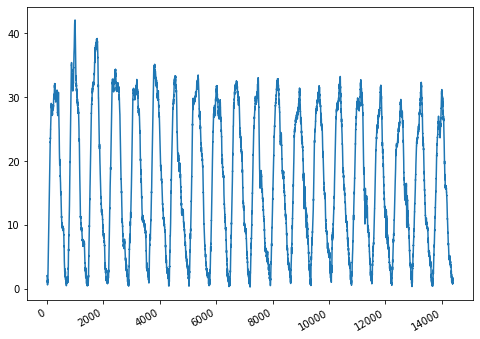

In [154]:
uni_data.plot(subplots=True)

In [155]:
uni_data = uni_data.values

In [156]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [157]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [158]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [159]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target TEC to predict')
print (y_train_uni[0])

Single window of past history
[[-1.39285503]
 [-1.39144387]
 [-1.39875223]
 [-1.42369602]
 [-1.42165229]
 [-1.44114681]
 [-1.42325594]
 [-1.45869923]
 [-1.48717231]
 [-1.47877957]
 [-1.48895448]
 [-1.46467981]
 [-1.46290419]
 [-1.46724047]
 [-1.49581416]
 [-1.5279739 ]
 [-1.49340236]
 [-1.48272126]
 [-1.49121556]
 [-1.48929057]
 [-1.47615957]
 [-1.44535516]
 [-1.4677267 ]
 [-1.4953397 ]
 [-1.48591741]
 [-1.48240912]
 [-1.47779129]
 [-1.47484086]
 [-1.42569346]
 [-1.4005611 ]]

 Target TEC to predict
-1.3901324389060024


In [160]:
def create_time_steps(length):
  return list(range(-length, 0))

In [161]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\yash\\Miniconda3\\envs\\TEC\\lib\\site-packages\\matplotlib\\pyplot.py'>

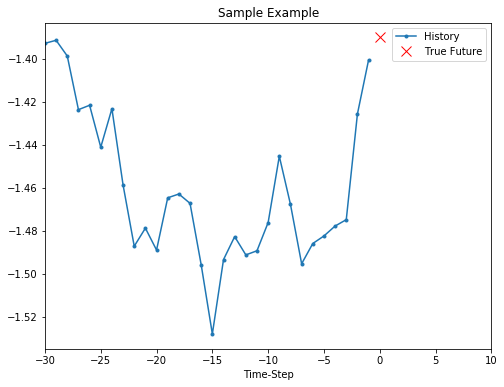

In [162]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [163]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\yash\\Miniconda3\\envs\\TEC\\lib\\site-packages\\matplotlib\\pyplot.py'>

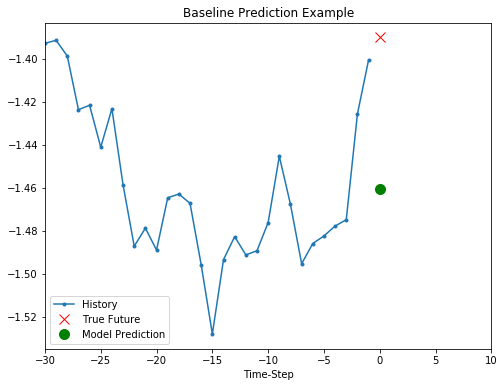

In [164]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [165]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [166]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [167]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

In [168]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

ValueError: in converted code:

    C:\Users\yash\Miniconda3\envs\TEC\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py:677 map_fn
        batch_size=None)
    C:\Users\yash\Miniconda3\envs\TEC\lib\site-packages\tensorflow_core\python\keras\engine\training.py:2410 _standardize_tensors
        exception_prefix='input')
    C:\Users\yash\Miniconda3\envs\TEC\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected lstm_5_input to have 3 dimensions, but got array with shape (None, 1)
